In [1]:
# GoogleFinance
# Data Clean up
# Health Care Monte Carlo
# Industrials Monte Carlo
# Utilities Monte Carlo

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os 
import seaborn as sns
from dotenv import load_dotenv

%matplotlib inline

In [3]:
#Try ALPACA data retrieval next
load_dotenv()

API_KEY_ID = os.getenv("API_KEY_ID")
SECRET_KEY = os.getenv("SECRET_KEY")

api = tradeapi.REST(API_KEY_ID, SECRET_KEY, api_version='v2')

type(API_KEY_ID)

str

In [4]:
#Use alpha vantage to get historic quotes for XLV, XLI, XLU. This goes back 20 years.

health_df = api.alpha_vantage.historic_quotes('XLV', adjusted=True, output_format='pandas')
health_df.head()

industrial_df = api.alpha_vantage.historic_quotes('XLI', adjusted=True, output_format='pandas')
# industrial_df.tail()

utilities_df = api.alpha_vantage.historic_quotes('XLU', adjusted=True, output_format='pandas')
# utilities_df.head()
sp500_df = api.alpha_vantage.historic_quotes('SPY', adjusted=True, output_format='pandas')

In [5]:
sp500_df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-04-30,291.71,293.3239,288.59,290.48,290.48,113667554.0,0.0,1.0
2020-04-29,291.53,294.8800,290.41,293.21,293.21,118066585.0,0.0,1.0
2020-04-28,291.02,291.4000,285.40,285.73,285.73,104797847.0,0.0,1.0
2020-04-27,285.12,288.2700,284.62,287.05,287.05,77516422.0,0.0,1.0
2020-04-24,280.73,283.7000,278.50,282.97,282.97,85042563.0,0.0,1.0


In [6]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

health_df = health_df['5. adjusted close']
health_df.head()

industrial_df = industrial_df['5. adjusted close']
industrial_df.head()

utilities_df = utilities_df['5. adjusted close']
utilities_df.head()

sp500_df = sp500_df['5. adjusted close']
sp500_df.head()

#Use concat to put the data in one dataframe
concat_df = pd.concat([health_df, industrial_df, utilities_df, sp500_df], axis = "columns", join = "inner")
concat_df.head()

,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close
date,,,,
2020-04-30,99.73,64.21,57.26,290.48
2020-04-29,100.19,65.51,58.61,293.21
2020-04-28,99.53,64.28,59.15,285.73
2020-04-27,101.58,63.10,58.93,287.05
2020-04-24,100.29,61.57,58.32,282.97


In [7]:
#Change column names to avoid confusion
columns = ['HealthCare_close', 'Industrials_close', 'Utilities_close', 'SP500_close']
concat_df.columns = columns
concat_df.head()

,HealthCare_close,Industrials_close,Utilities_close,SP500_close
date,,,,
2020-04-30,99.73,64.21,57.26,290.48
2020-04-29,100.19,65.51,58.61,293.21
2020-04-28,99.53,64.28,59.15,285.73
2020-04-27,101.58,63.10,58.93,287.05
2020-04-24,100.29,61.57,58.32,282.97


In [8]:
#add another column to get daily returns of XLB
daily_returns_health = health_df.pct_change()
concat_df['HealthCare_return']= daily_returns_health 

#add another column to get daily returns of XLK
daily_returns_industrial = industrial_df.pct_change()
concat_df['Industrials_return']= daily_returns_industrial 

#add another column to get daily returns of RWR
daily_returns_utilities = utilities_df.pct_change()
concat_df['Utilities_return']= daily_returns_utilities

#add another column to get daily returnds of SP500
daily_returns_sp500 = sp500_df.pct_change()
concat_df['SP500_return']= daily_returns_sp500

concat_df.head()

,HealthCare_close,Industrials_close,Utilities_close,SP500_close,HealthCare_return,Industrials_return,Utilities_return,SP500_return
date,,,,,,,,
2020-04-30,99.73,64.21,57.26,290.48,NaN,NaN,NaN,NaN
2020-04-29,100.19,65.51,58.61,293.21,0.004612,0.020246,0.023577,0.009398
2020-04-28,99.53,64.28,59.15,285.73,-0.006587,-0.018776,0.009213,-0.025511
2020-04-27,101.58,63.10,58.93,287.05,0.020597,-0.018357,-0.003719,0.004620
2020-04-24,100.29,61.57,58.32,282.97,-0.012699,-0.024247,-0.010351,-0.014214


In [9]:
# Drop nulls
concat_df.dropna(inplace=True)

#count nulls again
concat_df.isnull().sum()

HealthCare_close      0
Industrials_close     0
Utilities_close       0
SP500_close           0
HealthCare_return     0
Industrials_return    0
Utilities_return      0
SP500_return          0
dtype: int64

In [10]:
# Checking for duplicate rows
concat_df.duplicated()

date
2020-04-29    False
2020-04-28    False
2020-04-27    False
2020-04-24    False
2020-04-23    False
              ...  
2000-05-05    False
2000-05-04    False
2000-05-03    False
2000-05-02    False
2000-05-01    False
Length: 5031, dtype: bool

In [11]:
# drop duplicates
concat_df.drop_duplicates(inplace=True)
concat_df.head()

,HealthCare_close,Industrials_close,Utilities_close,SP500_close,HealthCare_return,Industrials_return,Utilities_return,SP500_return
date,,,,,,,,
2020-04-29,100.19,65.51,58.61,293.21,0.004612,0.020246,0.023577,0.009398
2020-04-28,99.53,64.28,59.15,285.73,-0.006587,-0.018776,0.009213,-0.025511
2020-04-27,101.58,63.10,58.93,287.05,0.020597,-0.018357,-0.003719,0.004620
2020-04-24,100.29,61.57,58.32,282.97,-0.012699,-0.024247,-0.010351,-0.014214
2020-04-23,98.96,61.08,57.96,279.08,-0.013262,-0.007958,-0.006173,-0.013747


In [12]:
# drop close columns to create dataframe for daily returns
returns_df = concat_df.drop(columns=['HealthCare_close', 'Industrials_close', 'Utilities_close', 'SP500_close'])
returns_df.head()

,HealthCare_return,Industrials_return,Utilities_return,SP500_return
date,,,,
2020-04-29,0.004612,0.020246,0.023577,0.009398
2020-04-28,-0.006587,-0.018776,0.009213,-0.025511
2020-04-27,0.020597,-0.018357,-0.003719,0.004620
2020-04-24,-0.012699,-0.024247,-0.010351,-0.014214
2020-04-23,-0.013262,-0.007958,-0.006173,-0.013747


In [13]:
# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_health = (1 + returns_df['HealthCare_return']).cumprod()
cumulative_returns_industrial = (1 + returns_df['Industrials_return']).cumprod()
cumulative_returns_utilities = (1 + returns_df['Utilities_return']).cumprod()
cumulative_returns_sp500 = (1 + returns_df['SP500_return']).cumprod()

In [14]:
cumulative_returns_health.head()

date
2020-04-29    1.004612
2020-04-28    0.997995
2020-04-27    1.018550
2020-04-24    1.005615
2020-04-23    0.992279
Name: HealthCare_return, dtype: float64

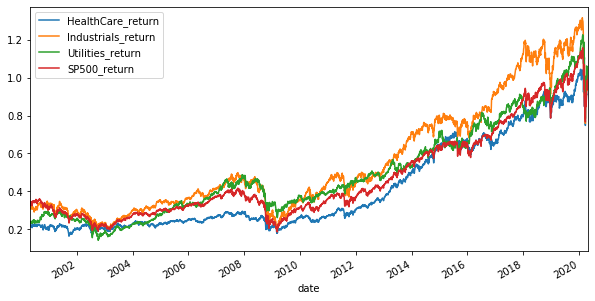

In [15]:
#plot cumulative returns

cumulative_returns_health.plot(figsize=(10,5), legend=True)
cumulative_returns_industrial.plot(figsize=(10,5), legend=True)
cumulative_returns_utilities.plot(figsize=(10,5), legend=True)
cumulative_returns_sp500.plot(figsize=(10,5), legend=True)

In [16]:
# Calculate Standard Deviations for each sector
HealthCare_std = returns_df['HealthCare_return'].std()
print(f' Healthcare standard deviation is {HealthCare_std}')


Industrials_std = returns_df['Industrials_return'].std()
print(f' Industrials standard deviation is {Industrials_std}')

Utilities_std = returns_df['Utilities_return'].std()
print(f' Utilities standard deviation is {Utilities_std}')

SP500_std = returns_df['SP500_return'].std()
print(f' S&P 500 standard deviation is {SP500_std}')


# Identify the sector with highest standard deviation (riskiest)
sectors = [HealthCare_std, Industrials_std, Utilities_std, SP500_std]
print(sectors)

 Healthcare standard deviation is 0.011677034238387628
 Industrials standard deviation is 0.013833999074919235
 Utilities standard deviation is 0.012405303993189763
 S&P 500 standard deviation is 0.012464342327618443
[0.011677034238387628, 0.013833999074919235, 0.012405303993189763, 0.012464342327618443]


In [17]:
# Calculate the annualized standard deviation (252 trading days) for each sector
annual_HealthCare_std = HealthCare_std * np.sqrt(252)
annual_HealthCare_std

annual_Industrials_std = Industrials_std * np.sqrt(252)
annual_Industrials_std

annual_Utilities_std = Utilities_std * np.sqrt(252)
annual_Utilities_std

annual_SP500_std = SP500_std * np.sqrt(252)
annual_SP500_std

0.1978653003291262

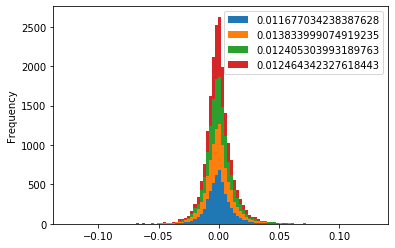

In [18]:
#Plot

sectors_std = pd.DataFrame({
    HealthCare_std: returns_df['HealthCare_return'],
    Industrials_std: returns_df['Industrials_return'],
    Utilities_std: returns_df['Utilities_return'],
    SP500_std: returns_df['SP500_return']
})

sectors_std.plot.hist(stacked=True, bins=100)

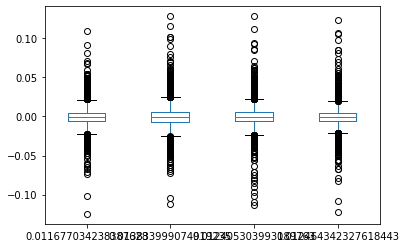

In [19]:
sectors_std.plot.box()

In [20]:
# Calculate Sharpe Ratios for the sectors

HealthCare_sharpe = (returns_df['HealthCare_return'].mean() * 252) / (returns_df['HealthCare_return'].std() * np.sqrt(252))

Industrials_sharpe = (returns_df['Industrials_return'].mean() * 252) / (returns_df['Industrials_return'].std() * np.sqrt(252))

Utilities_sharpe = (returns_df['Utilities_return'].mean() * 252) / (returns_df['Utilities_return'].std() * np.sqrt(252))

SP500_sharpe = (returns_df['SP500_return'].mean() * 252) / (returns_df['SP500_return'].std() * np.sqrt(252))

print(f" HealthCare: {HealthCare_sharpe}, Industrials: {Industrials_sharpe}, Utilities:{Utilities_sharpe}, S&P 500: {SP500_sharpe}")

 HealthCare: -0.309142879058624, Industrials: -0.14904169363144829, Utilities:-0.26469607829343605, S&P 500: -0.16949976566089006


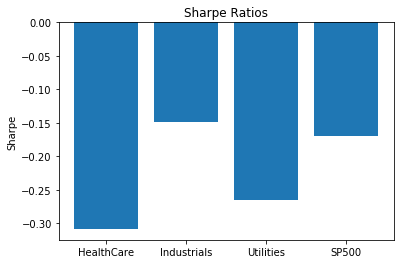

In [21]:
#Plot the sharpe ratios

objects = ('HealthCare', 'Industrials', 'Utilities', 'SP500')
y_pos = np.arange(len(objects))
sharpe = [HealthCare_sharpe,Industrials_sharpe,Utilities_sharpe, SP500_sharpe]

plt.bar(y_pos, sharpe, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Sharpe')
plt.title('Sharpe Ratios')

plt.show()

In [22]:
# Drop nulls on Returns
returns_df.dropna(inplace=True)

#count nulls 
returns_df.isnull().sum()

HealthCare_return     0
Industrials_return    0
Utilities_return      0
SP500_return          0
dtype: int64

In [23]:
#Check correlation

sector_correlation = returns_df.corr()
sector_correlation

,HealthCare_return,Industrials_return,Utilities_return,SP500_return
HealthCare_return,1.000000,0.738462,0.553251,0.807066
Industrials_return,0.738462,1.000000,0.567942,0.905134
Utilities_return,0.553251,0.567942,1.000000,0.646925
SP500_return,0.807066,0.905134,0.646925,1.000000


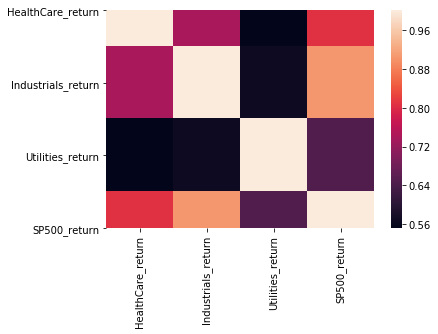

In [24]:
# Heapmap to visualize sector correlation
sns.heatmap(sector_correlation)

In [26]:
#BETA CALCULATION Healthcare Sector and S&P 500

# Calculate covariance of Healthcare vs. S&P 500
health_covariance = returns_df['HealthCare_return'].cov(returns_df['SP500_return'])
health_covariance

# Calculate variance of S&P 500 returns
variance = returns_df['SP500_return'].var()
variance

# Calculate beta of Healthcare Sector
HealthCare_beta = health_covariance / variance
HealthCare_beta

0.756088023009645

In [28]:
#BETA CALCULATION Industrial Sector and S&P 500

# Calculate covariance of Industrials vs. S&P 500
industrials_covariance = returns_df['Industrials_return'].cov(returns_df['SP500_return'])
industrials_covariance

# Calculate variance of S&P 500 returns
variance = returns_df['SP500_return'].var()
variance

# Calculate beta of Industrial Sector
Industrials_beta = industrials_covariance / variance
Industrials_beta

1.0045956330018098

In [29]:
#BETA CALCULATION Utilities and S&P 500

# Calculate covariance of Utilities vs. S&P 500
utilities_covariance = returns_df['Utilities_return'].cov(returns_df['SP500_return'])
utilities_covariance

# Calculate variance of S&P 500 returns
variance = returns_df['SP500_return'].var()
variance

# Calculate beta of Utilities Sector
Utilities_beta = utilities_covariance / variance
Utilities_beta

0.6438612129876659

A 10,000 investment in the Healthcare Sector would have decreased to 9979.945853805275


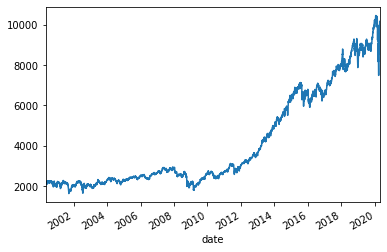

In [37]:
# Plot the monetary returns of HealthCare Sector 
initial_investment = 10000
cumulative_profit_health = initial_investment * cumulative_returns_health
print(f'A 10,000 investment in the Healthcare Sector would have decreased to {cumulative_profit_health[1]}')
cumulative_profit_health.plot()

A 10,000 investment in the Healthcare Sector would have grown to 10010.901728702695


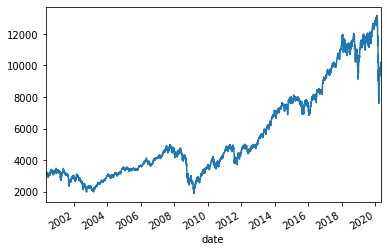

In [34]:
# Plot the monetary returns of Industrial Sector 
initial_investment = 10000
cumulative_profit_industrial = initial_investment * cumulative_returns_industrial
print(f'A 10,000 investment in the Healthcare Sector would have grown to {cumulative_profit_industrial[1]}')
cumulative_profit_industrial.plot()

A 10,000 investment in the Healthcare Sector would have grown to 10330.07334963325


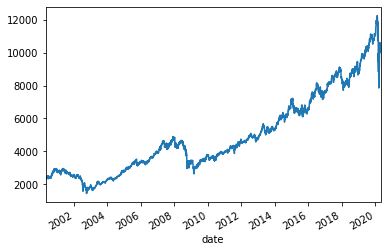

In [36]:
# Plot the monetary returns of Utilities Sector 
initial_investment = 10000
cumulative_profit_utilities = initial_investment * cumulative_returns_utilities
print(f'A 10,000 investment in the Healthcare Sector would have grown to {cumulative_profit_utilities[1]}')
cumulative_profit_utilities.plot()

In [38]:
#START MONTE CARLO ANALYSIS (HealthCare)

#check concat_df
concat_df.head()

,HealthCare_close,Industrials_close,Utilities_close,SP500_close,HealthCare_return,Industrials_return,Utilities_return,SP500_return
date,,,,,,,,
2020-04-29,100.19,65.51,58.61,293.21,0.004612,0.020246,0.023577,0.009398
2020-04-28,99.53,64.28,59.15,285.73,-0.006587,-0.018776,0.009213,-0.025511
2020-04-27,101.58,63.10,58.93,287.05,0.020597,-0.018357,-0.003719,0.004620
2020-04-24,100.29,61.57,58.32,282.97,-0.012699,-0.024247,-0.010351,-0.014214
2020-04-23,98.96,61.08,57.96,279.08,-0.013262,-0.007958,-0.006173,-0.013747
